# Objective
The objetive of this notebook is to replicate example of section 12.1 https://otexts.com/fpp3/complexseasonality.html.

# Description of the data
The number of calls to a North American commercial bank per 5-minute interval between 7:00am and 9:05pm each weekday over a 33 week period. There is a strong daily seasonal pattern with period 169 (there are 169 5-minute intervals per day), and a weak weekly seasonal pattern with period 169×5=845.
 

# Imports, configuration and constants

In [2]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
from sktime.forecasting.trend import STLForecaster
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [39]:
PLOT_TITLE = "AUS cement production"
PLOT_YLABEL = "Cement"
PLOT_XLABEL = "Quarter"

# Load data

In [23]:
data_dir_path = "../data-raw/"
aus_production_path = path.join(data_dir_path, "aus_production.csv")

df = pd.read_csv(aus_production_path, sep='|')
df.columns = df.columns.str.lower()

In [31]:
df = df.rename(columns={"quarter": "year_quarter"})

In [33]:
# Split the 'year_quarter' column into separate 'year' and 'quarter' columns
df[['year', 'quarter']] = df['year_quarter'].str.split(' Q', expand=True)

# Combine the 'year' and 'quarter' columns into a datetime column
df['date'] = pd.PeriodIndex(year=df['year'].astype(int), quarter=df['quarter'].astype(int)).to_timestamp()

# Drop the 'year_quarter', 'year', and 'quarter' columns
df = df.drop(columns=['year_quarter', 'year', 'quarter'])

In [35]:
print(df)

     beer  tobacco  bricks  cement  electricity  gas       date
0     284   5225.0   189.0     465         3923    5 1956-01-01
1     213   5178.0   204.0     532         4436    6 1956-04-01
2     227   5297.0   208.0     561         4806    7 1956-07-01
3     308   5681.0   197.0     570         4418    6 1956-10-01
4     262   5577.0   187.0     529         4339    5 1957-01-01
..    ...      ...     ...     ...          ...  ...        ...
213   398      NaN     NaN    2160        57471  238 2009-04-01
214   419      NaN     NaN    2325        58394  252 2009-07-01
215   488      NaN     NaN    2273        57336  210 2009-10-01
216   414      NaN     NaN    1904        58309  205 2010-01-01
217   374      NaN     NaN    2401        58041  236 2010-04-01

[218 rows x 7 columns]


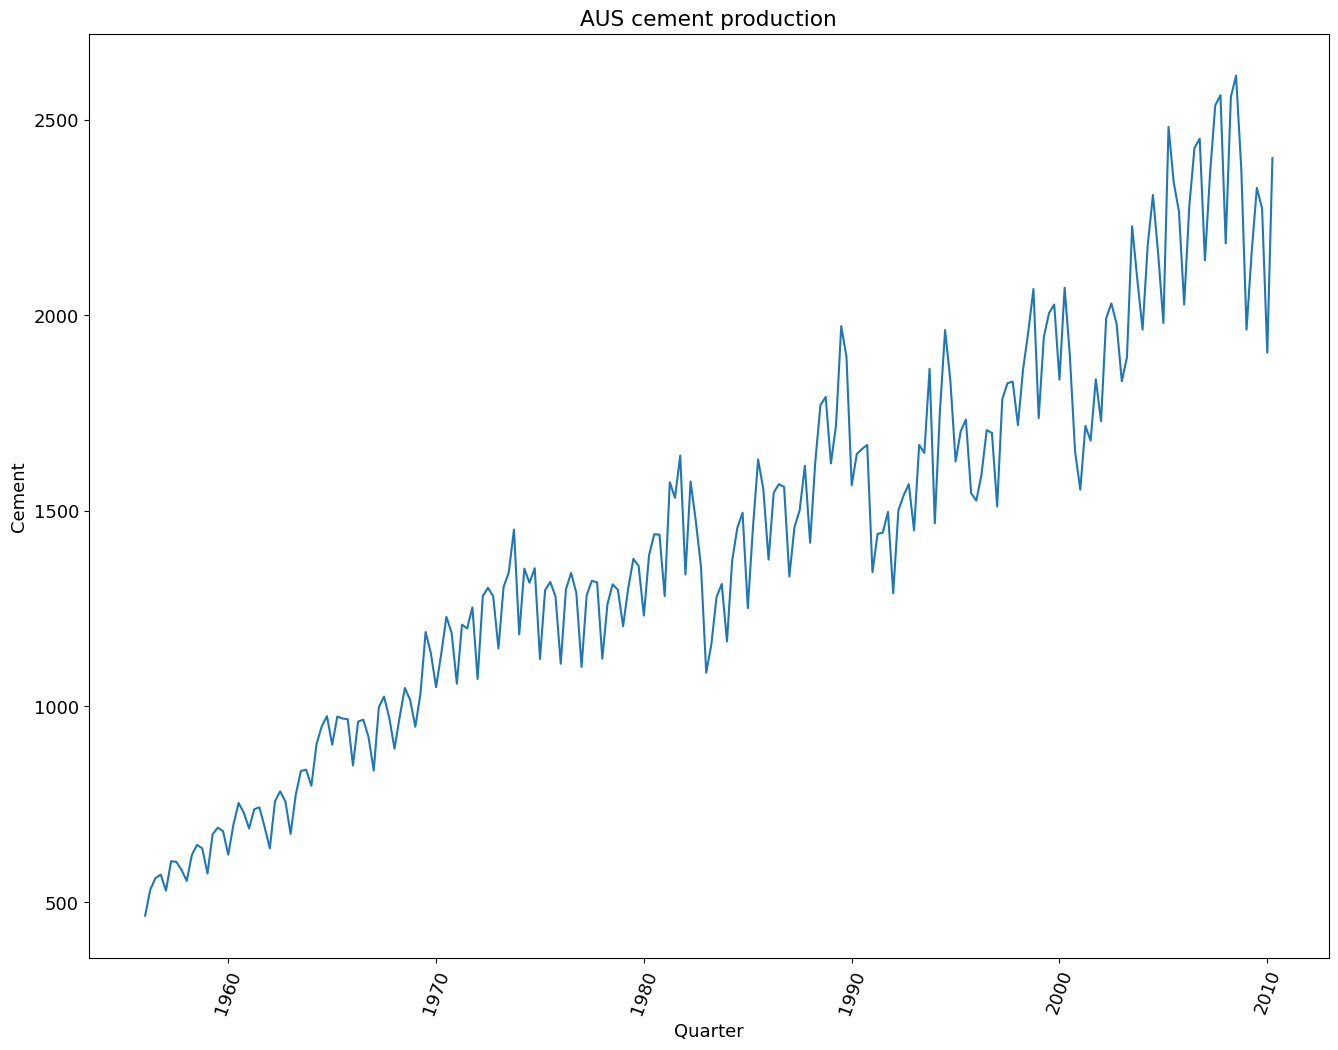

In [40]:
plot_cement_df(df)

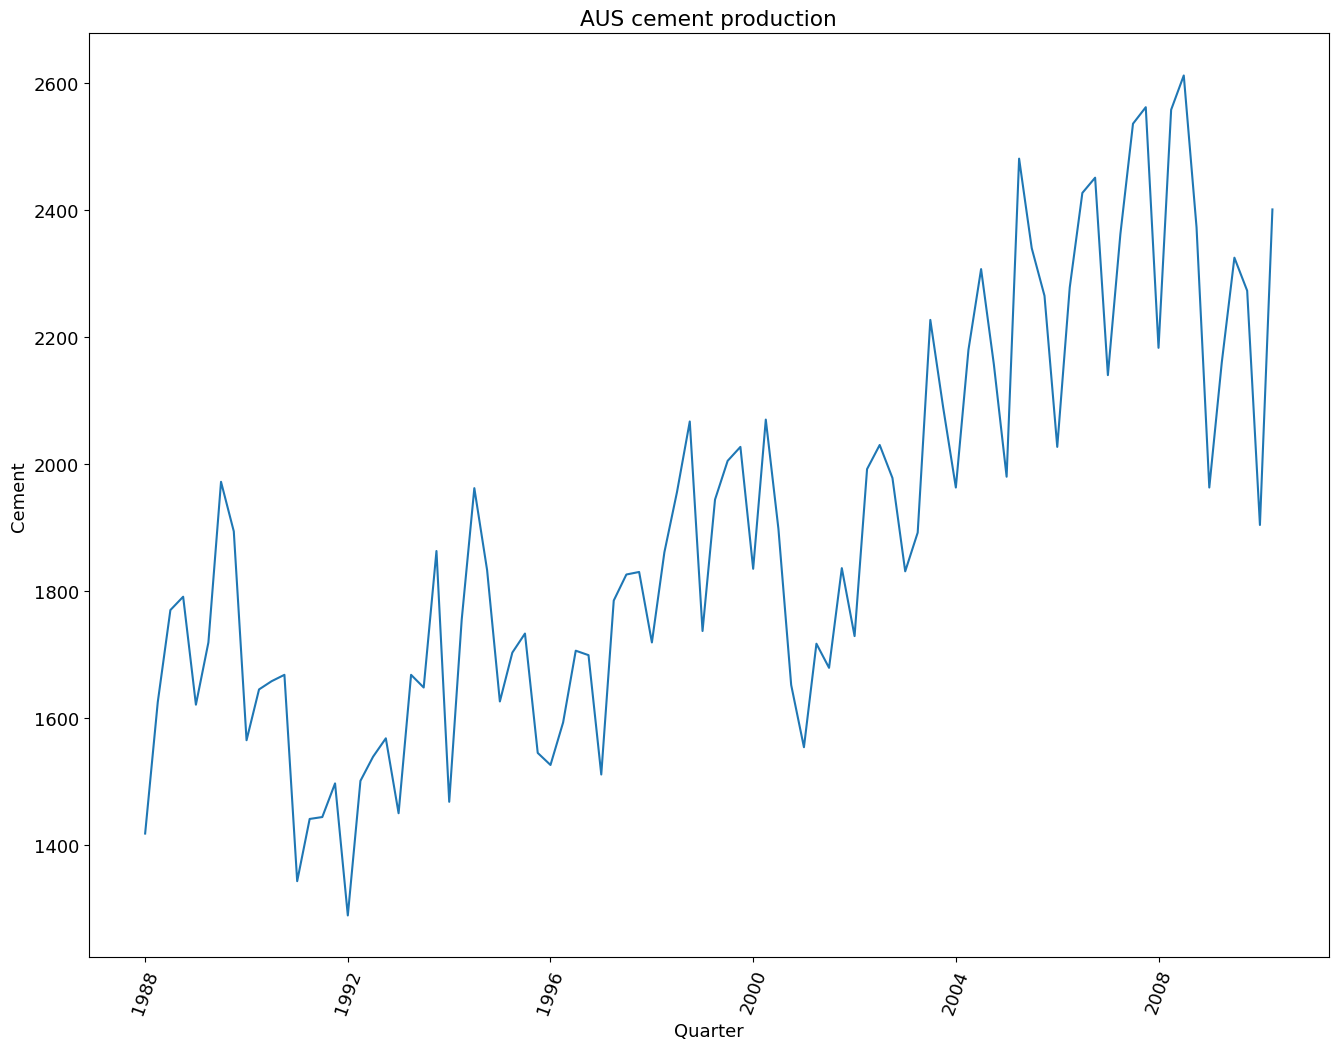

In [41]:
plot_cement_df(df, start_time=1988)

In [42]:
df

,beer,tobacco,bricks,cement,electricity,gas,date
0,284,5225.0,189.0,465,3923,5,1956-01-01
1,213,5178.0,204.0,532,4436,6,1956-04-01
2,227,5297.0,208.0,561,4806,7,1956-07-01
3,308,5681.0,197.0,570,4418,6,1956-10-01
4,262,5577.0,187.0,529,4339,5,1957-01-01
...,...,...,...,...,...,...,...
213,398,NaN,NaN,2160,57471,238,2009-04-01
214,419,NaN,NaN,2325,58394,252,2009-07-01
215,488,NaN,NaN,2273,57336,210,2009-10-01
216,414,NaN,NaN,1904,58309,205,2010-01-01


In [43]:
df = df[["cement", "date"]]

In [58]:
df = df[df.date >= "1988-01-01"]

In [59]:
ts = pd.Series(df.cement.values, index=df.date)

In [60]:
ts

date
1988-01-01    1418
1988-04-01    1625
1988-07-01    1770
1988-10-01    1791
1989-01-01    1621
              ... 
2009-04-01    2160
2009-07-01    2325
2009-10-01    2273
2010-01-01    1904
2010-04-01    2401
Length: 90, dtype: int64

In [63]:
ts_train = ts[ts.index <= "2007-01-01"]

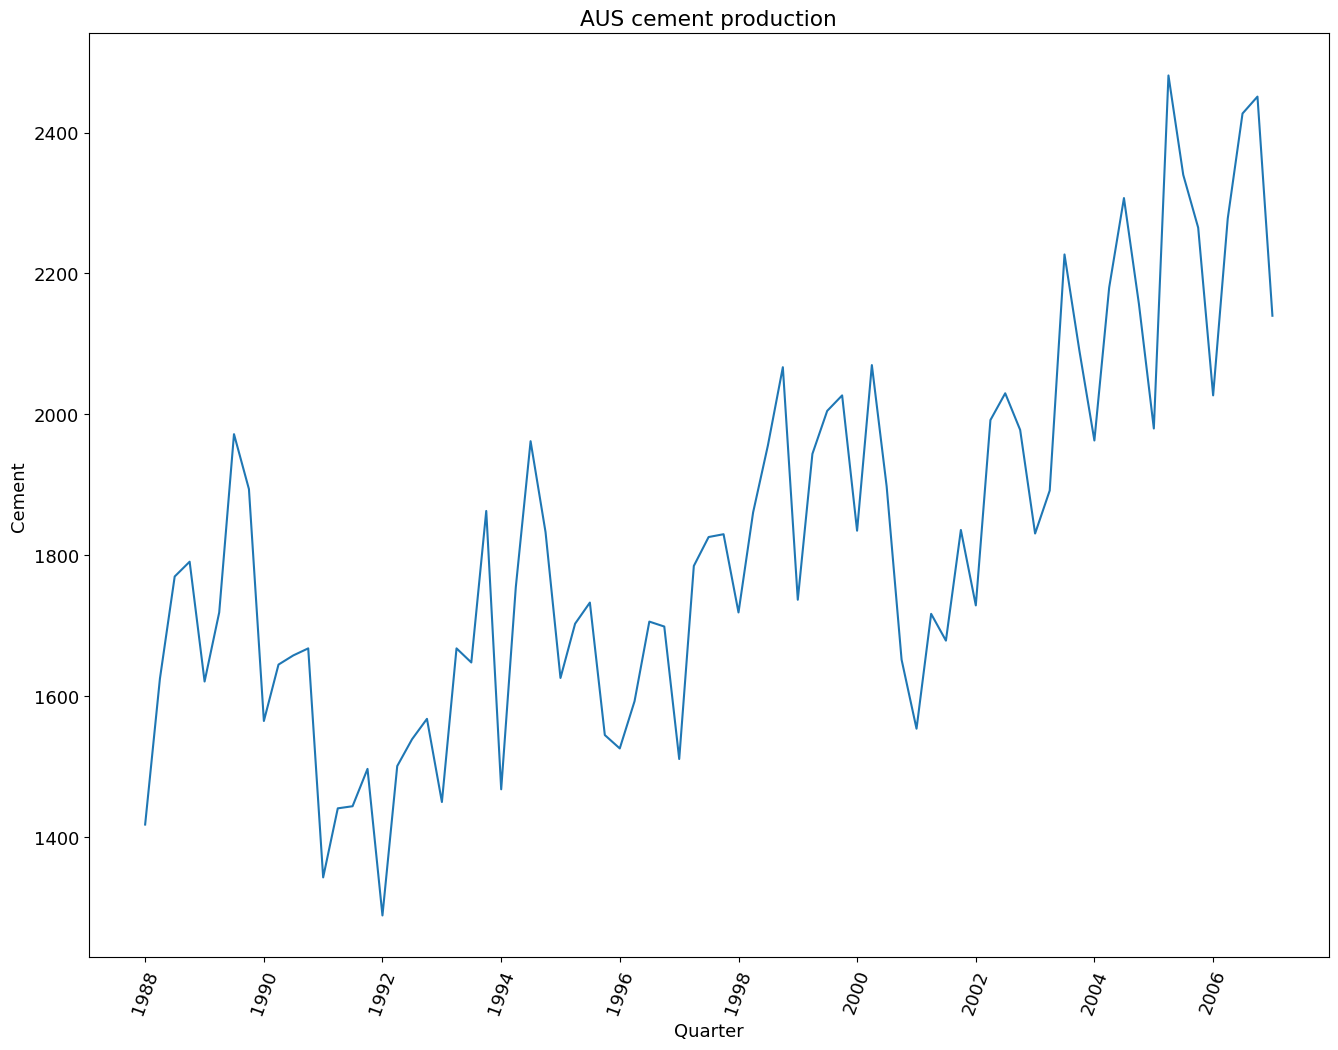

In [64]:
plot_cement_ts(ts_train)

Model: ARIMA(1,0,1)(2,1,1)[4] w/ drift 

In [66]:
arima = ARIMA(endog=ts_train, order=(1,0,1), seasonal_order=(2,1,1,4))
res = arima.fit()

/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [69]:
print(res.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                   77
Model:             ARIMA(1, 0, 1)x(2, 1, 1, 4)   Log Likelihood                -447.370
Date:                         Wed, 05 Apr 2023   AIC                            906.740
Time:                                 18:40:48   BIC                            920.483
Sample:                             01-01-1988   HQIC                           912.217
                                  - 01-01-2007                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.049     20.308      0.000       0.903       1.096
ma.L1         -0.3028      0.118     -2.557      0.011     

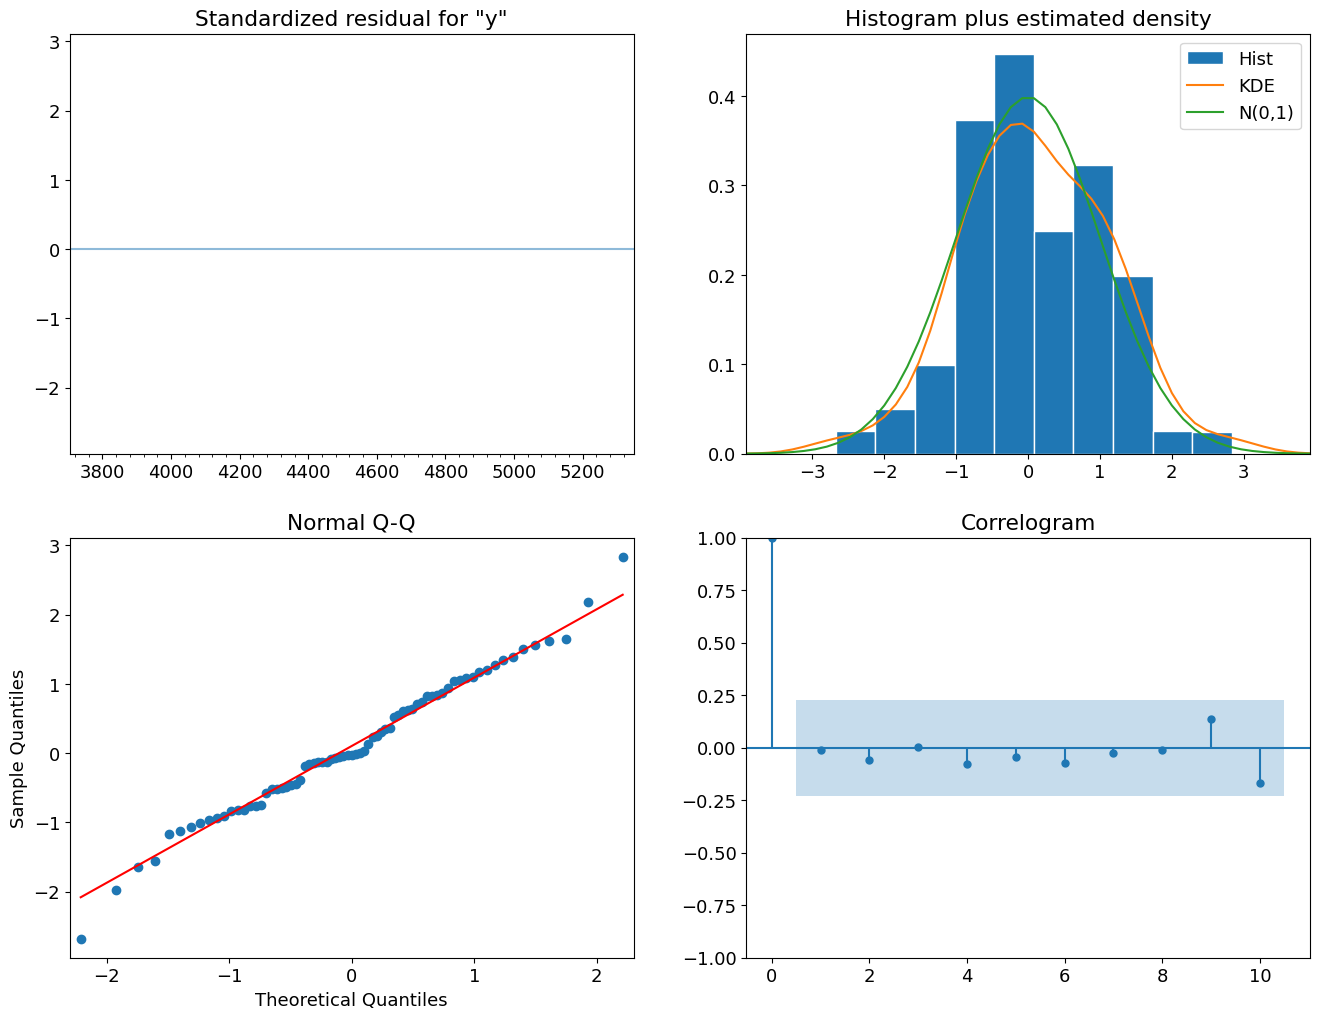

In [72]:
res.plot_diagnostics();

In [73]:
ts

date
1988-01-01    1418
1988-04-01    1625
1988-07-01    1770
1988-10-01    1791
1989-01-01    1621
              ... 
2009-04-01    2160
2009-07-01    2325
2009-10-01    2273
2010-01-01    1904
2010-04-01    2401
Length: 90, dtype: int64

In [74]:
ts_train

date
1988-01-01    1418
1988-04-01    1625
1988-07-01    1770
1988-10-01    1791
1989-01-01    1621
              ... 
2006-01-01    2027
2006-04-01    2278
2006-07-01    2427
2006-10-01    2451
2007-01-01    2140
Length: 77, dtype: int64

In [ ]:
pred = res.get_prediction(
    start=len(sqrt_ts), 
    end=sqrt_ts.index.max() + 169*5,
    exog=df_fourier_pred
)

df_pred = pred.summary_frame(alpha=0.05)

# Functions

In [54]:
def fill_gaps_df(df: pd.DataFrame) -> pd.DataFrame:

    # Set the index to be the datetime column
    df = df.set_index('datetime')
    # Resample to 5-minute intervals, filling any missing values with NaN
    df = df.resample('5T').asfreq()
    
    df = df.reset_index()
    
    return df


def fill_gaps_ts(ts: pd.Series) -> pd.Series:

    # Resample to 5-minute intervals, filling any missing values with NaN
    ts = ts.resample('5T').asfreq()
    
    return ts


def plot_cement_df(df: pd.DataFrame, start_time: str=None, end_time: str=None):
    
    df = df.copy()
    
    if start_time is not None:
        df = df.query('date >= @start_time')
    if end_time is not None:
        df = df.query('date <= @end_time')
        
    x = df.date
    y = df.cement
    
    plt.plot(x, y)
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    plt.show()
    
    
def plot_cement_ts(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None,
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None
):
    
    if start_time is not None:
        ts = ts[ts.index >= start_time]
        if lower_ci is not None:
            lower_ci = lower_ci[ts.index]
        if upper_ci is not None:
            upper_ci = upper_ci[ts.index]
        
    if end_time is not None:
        ts = ts[ts.index <= end_time]
        if lower_ci is not None:
            lower_ci = lower_ci[ts.index]
        if upper_ci is not None:
            upper_ci = upper_ci[ts.index]
    
    x = ts.index
    y = ts
    
    plt.plot(x, y)
    
    if lower_ci is not None and upper_ci is not None:
        plt.fill_between(x, lower_ci, upper_ci, alpha=0.2, label='Confidence Interval')
        plt.legend(loc='upper left')
    
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    plt.show()
    
    
def reconstruct_h_index(
    ts_h: pd.Series,
    ts_h_lower: pd.Series,
    ts_h_upper: pd.Series
):
    
    forecast_index = []

    period = (
        pd.period_range(
            start="2003-10-27 07:00:00", 
            end="2003-10-31 21:00:00", 
            freq='5T'
        )
        .to_timestamp()
    )

    for datetime in period:

        if datetime.hour >= 7 and datetime.hour < 21:
            forecast_index.append(datetime)
        elif datetime.hour == 21 and datetime.minute < 5:
            forecast_index.append(datetime)

    ts_h.index = forecast_index
    ts_h_lower.index = forecast_index
    ts_h_upper.index = forecast_index
    
    
def join_forecast_to_series(
    ts: pd.Series,
    ts_index: pd.Index,
    ts_h: pd.Series,
    ts_h_lower: pd.Series,
    ts_h_upper: pd.Series
) -> tuple[pd.Series, pd.Series, pd.Series]:
    
    ts_with_h = ts.copy()
    # Recovering the series index
    ts_with_h.index = ts_index
    ts_with_h = pd.concat([ts_with_h, ts_h])

    ts_with_h_lower = ts_with_h.copy()
    ts_with_h_lower[ts.index] = None
    ts_with_h_lower[ts_h_lower.index] = ts_h_lower

    ts_with_h_upper = ts_with_h.copy()
    ts_with_h_upper[ts.index] = None
    ts_with_h_upper[ts_h_upper.index] = ts_h_upper
    
    # Filling the gaps
    ts_with_h = fill_gaps_ts(ts_with_h)
    ts_with_h_lower = fill_gaps_ts(ts_with_h_lower)
    ts_with_h_upper = fill_gaps_ts(ts_with_h_upper)
    
    return ts_with_h, ts_with_h_lower, ts_with_h_upper

    
def _get_fourier_terms(t: int, m: int, k: int) -> pd.DataFrame:
    
    sin_term_tag = f"sin_m{m}_k{k}"
    cos_term_tag = f"cos_m{m}_k{k}"
    
    sin_terms = [
        np.sin((k*np.pi*ti) / m)
        for ti in range(t)
    ]
    cos_terms = [
        np.cos((k*np.pi*ti) / m)
        for ti in range(t)
    ]
    
    df = pd.DataFrame({
        sin_term_tag: sin_terms,
        cos_term_tag: cos_terms
    })
    
    return df


def fourier(t: int, period: int, n_terms: int) -> pd.DataFrame:
    
    return pd.concat(
        [
            _get_fourier_terms(t, period, k*2)
            for k in range(1, int(n_terms) + 1)
        ],
        axis=1
    )


def get_best_arima_model(endog, exog, orders):
    
    best_res = None
    best_aicc = np.inf
    
    for order in orders:
        print(f"Fitting ARIMA order {order}...")
        arima = ARIMA(endog=endog, exog=exog, order=order)
        res = arima.fit()
        
        if res.aicc < best_aicc:
            best_res = res
            best_aicc = res.aicc
        
    return best_res

# Visualize data
There is daily (169 measures) and weekly seasonality (169*5 measures).

In [5]:
# Filling gaps with NaN so that those points are not interpolated in the plot
df_filled = fill_gaps_df(df)